## Acoustic Scattering Produced by a Circular Obstacle in an Infinite Domain

In [6]:
%load_ext autoreload
%autoreload 2
#--------------------------------------------------------------
# utf-8

# Standard library imports
import sys
import os
import numpy as np
from scipy.interpolate import griddata

# Set the current directory and utilities path
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Import Functions
from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement
from analytical_solution_functions import plot_exact_displacement
from analytical_solution_functions import plot_pinns_displacements
from analytical_solution_functions import calculate_relative_errors
from pinns_solution_functions import generate_points
from pinns_solution_functions import plot_points
from pinns_solution_functions import initialize_and_load_model
from pinns_solution_functions import predict_displacement_pinns 
from pinns_solution_functions import process_displacement_pinns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameters of the model

In [2]:
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]

### Analytical Solution

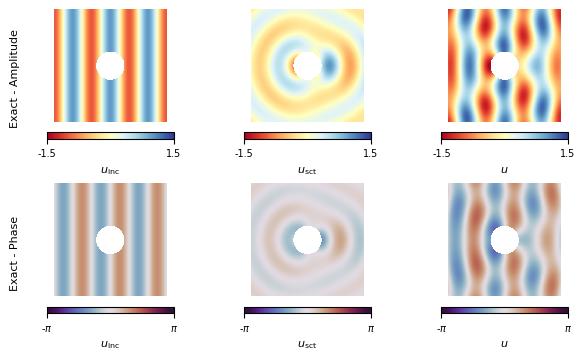

In [ ]:
 
# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

### Physics informed neural networks (PINNs)

#### Collocation points

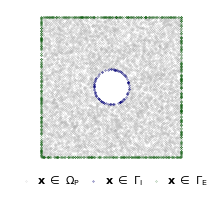

In [4]:
# Parameters
n_Omega_P = 10_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 250          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
l_e = np.pi              # Length of the semi-edge of the square
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * l_e    # Side length of the square

# Generate points
x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)
plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

#### Physics informed neural networks (PINNs) solution

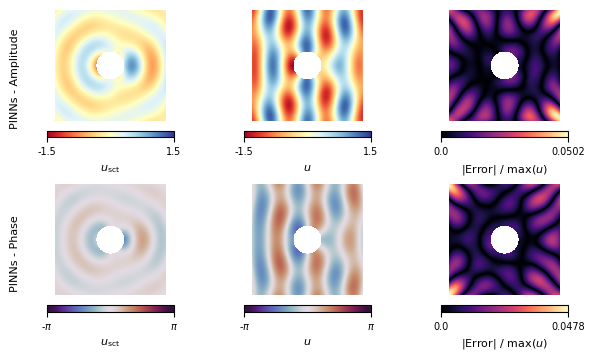

In [5]:
# Initialize and load the model
model_path = 'models/Scattering_2_75.pt'
model = initialize_and_load_model(model_path)

# Predict the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, n_grid)

# Example usage
u_sc_amp_pinns,u_sc_phase_pinns,u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
    model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
)

plot_pinns_displacements(X, Y, u_sc_amp_pinns, u_amp_pinns, diff_uscn_amp_pinns, u_sc_phase_pinns, u_phase_pinns, diff_u_scn_phase_pinns)

#### Accuracy

In [7]:
# Calculate and print the relative errors
rel_error_uscn_amp_pinns, rel_error_uscn_phase_pinns, max_diff_uscn_amp_pinns, min_diff_uscn_amp_pinns, max_diff_u_phase_pinns, min_diff_u_phase_pinns = calculate_relative_errors(u_scn_exact, u_exact, diff_uscn_amp_pinns, diff_u_scn_phase_pinns, R_exact, r_i)
mean_rel_error_pinns = (rel_error_uscn_amp_pinns + rel_error_uscn_phase_pinns) / 2
print(f"Relative error in the u_scn phase: {rel_error_uscn_phase_pinns:.2e}")
print(f"Max diff in the u_scn amp: {max_diff_uscn_amp_pinns:.2e}")
print(f"Min diff in the u_scn amp: {min_diff_uscn_amp_pinns:.2e}")
print(f"Max diff in the u_scn phase: {max_diff_u_phase_pinns:.2e}")
print(f"Min diff in the u_scn phase: {min_diff_u_phase_pinns:.2e}")

Relative error in the u_scn phase: 7.21e-02
Max diff in the u_scn amp: 7.43e-02
Min diff in the u_scn amp: -4.86e-02
Max diff in the u_scn phase: 4.79e-02
Min diff in the u_scn phase: -8.21e-02
